In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

<b> Import CPTAC </b>

In [2]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [3]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

# Difference in protein abundance 

In [5]:
gene = 'PIK3R1'
protList = ['IRS2']

pcutoff = 0.05/len(protList)
print(pcutoff)

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        proteinfindName = protein + "protein"
        proteindf.columns = [proteinfindName]
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[proteinfindName], wt[proteinfindName])
        print("Test for " + protein + ": ")
        print(ttest)

0.05
Test for IRS2: 
Ttest_indResult(statistic=-4.387580404733772, pvalue=3.20389610243306e-05)


<b> Plot the data </b>

[Text(0, 0.5, 'Proteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

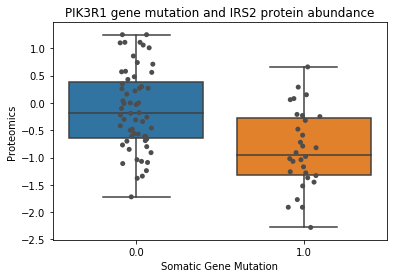

In [6]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=proteinfindName)
somatic_boxplot.set_title(gene + " gene mutation and " + protList[0] + " protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=proteinfindName,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

# Difference in phosphoproteome abundance 

In [9]:
gene = 'PIK3R1'
sites = phos.filter(regex='IRS2')
sigResults = [];

genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(sites, fill_value=0)
mutated = cross.loc[cross[gene] == 1.0]
wt = cross.loc[cross[gene] == 0.0]

pcutoff = 0.05/len(cross.columns)
print(pcutoff)
#pcutoff = 1

for loc in cross.columns:
    if not loc == gene:
        mutsitedf = mutated[[gene, loc]].dropna()
        wtsitedf = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(mutsitedf[loc], wtsitedf[loc])
        if ttest[1] <= pcutoff:
            sigResults.append(loc)
            print('Results for ' + loc + ': ')
            print(ttest)

0.0038461538461538464
Results for IRS2-S1100: 
Ttest_indResult(statistic=-4.019029388226416, pvalue=0.0001505481884237998)
Results for IRS2-S679: 
Ttest_indResult(statistic=-3.5414593756235186, pvalue=0.0007181350946428204)
Results for IRS2-S731: 
Ttest_indResult(statistic=-4.2075513087547245, pvalue=8.333919696760065e-05)


<b> Plot the data </b>

[Text(0, 0.5, 'Phosphoproteomics'), Text(0.5, 0, 'Somatic Gene Mutation')]

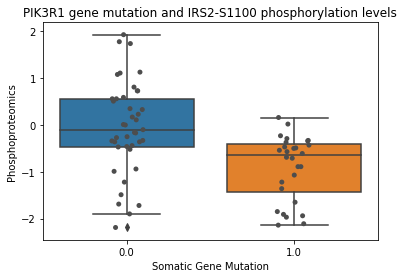

In [10]:
x = 0
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=sigResults[x])
somatic_boxplot.set_title(gene + " gene mutation and " + sigResults[x] + " phosphorylation levels")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=sigResults[x],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

<b> Conclusion: Protein and phosphoprotein abundance are lower when PIK3R1 is mutated </b>